In [ ]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd()
if ROOT.name == "src":
    ROOT = ROOT.parent

DB = ROOT / "data" / "database"

# --- Charger df_naq ---
df_naq_path = DB / "df_naq.parquet"
df_naq = pd.read_parquet(df_naq_path)
print("Shape df_naq :", df_naq.shape)
print(df_naq.columns)

# On crée une colonne MONTH (mais on ne touche pas à DATE d'origine)
df_naq["DATE"] = pd.to_datetime(df_naq["DATE"].astype(str), format="%Y%m%d")
df_naq["MONTH"] = df_naq["DATE"].dt.to_period("M").dt.to_timestamp()

# Agrégation mensuelle par département
df_naq_month = (
    df_naq
    .groupby(["DEPARTEMENT", "REGION", "MONTH"], as_index=False)
    .agg(SWI_mean=("SWI", "mean"))
)

print("Shape df_naq_month :", df_naq_month.shape)
df_naq_month.head()


Shape df_naq : (9679125, 17)
Index(['LAMBX', 'LAMBY', 'DATE', 'PRENEI', 'PRELIQ', 'T', 'FF', 'SWI',
       'SSWI_10J', 'ALEA', 'NIVEAU', 'DPT', 'ARGILES_FROM', 'dist_argiles_m',
       'COMMUNE', 'DEPARTEMENT', 'REGION'],
      dtype='object')
Shape df_naq_month : (2880, 4)


,DEPARTEMENT,REGION,MONTH,SWI_mean
0,16,75,2000-01-01,0.944257
1,16,75,2000-02-01,0.908732
2,16,75,2000-03-01,0.838971
3,16,75,2000-04-01,0.857900
4,16,75,2000-05-01,0.809854


In [2]:
df_naq["DATE_dt"] = pd.to_datetime(df_naq["DATE"])
df_naq["MONTH"] = df_naq["DATE_dt"].dt.to_period("M").dt.to_timestamp()


In [3]:
agg_specs = {
    "SWI": "mean",
    "PRENEI": "mean",
    "PRELIQ": "mean",
    "T": "mean",
    "FF": "mean",
    "SSWI_10J": "mean"
}

panel = (
    df_naq
    .groupby(["DEPARTEMENT", "MONTH"], as_index=False)
    .agg(**{col + "_mean": (col, func) for col, func in agg_specs.items()})
)

panel.rename(columns={"SWI_mean": "SWI"}, inplace=True)  # plus lisible
panel.head()


,DEPARTEMENT,MONTH,SWI,PRENEI_mean,PRELIQ_mean,T_mean,FF_mean,SSWI_10J_mean
0,16,2000-01-01,0.944257,0.014742,0.656850,4.102116,2.832258,0.399960
1,16,2000-02-01,0.908732,0.000037,3.373118,7.258547,3.004746,-0.094162
2,16,2000-03-01,0.838971,0.000867,1.283871,7.685883,2.810649,0.097560
3,16,2000-04-01,0.857900,0.000072,4.485341,10.632401,3.339892,0.651034
4,16,2000-05-01,0.809854,0.000000,2.843427,15.712937,2.360492,1.395165


In [ ]:
import geopandas as gpd
import numpy as np
import libpysal

# On part de df_naq déjà chargé
print(df_naq.shape)
print(df_naq.columns)

# Exemple : voir quelques dates disponibles
print(df_naq["DATE"].unique()[:10])


(9679125, 19)
Index(['LAMBX', 'LAMBY', 'DATE', 'PRENEI', 'PRELIQ', 'T', 'FF', 'SWI',
       'SSWI_10J', 'ALEA', 'NIVEAU', 'DPT', 'ARGILES_FROM', 'dist_argiles_m',
       'COMMUNE', 'DEPARTEMENT', 'REGION', 'MONTH', 'DATE_dt'],
      dtype='object')
<DatetimeArray>
['2000-01-01 00:00:00', '2000-01-02 00:00:00', '2000-01-03 00:00:00',
 '2000-01-04 00:00:00', '2000-01-05 00:00:00', '2000-01-06 00:00:00',
 '2000-01-07 00:00:00', '2000-01-08 00:00:00', '2000-01-09 00:00:00',
 '2000-01-10 00:00:00']
Length: 10, dtype: datetime64[ns]


In [ ]:

# Voir quelques dates dispo
print(df_naq["DATE_dt"].sort_values().head(10))

# Choisir une date (par ex. le 1er janvier 2000)
date_sel = pd.Timestamp("2000-01-01")
# ou : date_sel = df_naq["DATE_dt"].min()

df_day = df_naq[df_naq["DATE_dt"] == date_sel].copy()
print("Nb de points pour cette date :", df_day.shape[0])

# Optionnel : on échantillonne si c'est énorme
max_points = 20000
if len(df_day) > max_points:
    df_day = df_day.sample(max_points, random_state=0)
    print("Nb de points après sampling :", df_day.shape[0])

# GeoDataFrame de points en Lambert-93
gday = gpd.GeoDataFrame(
    df_day,
    geometry=gpd.points_from_xy(df_day["LAMBX"], df_day["LAMBY"]),
    crs="EPSG:2154"
)


0        2000-01-01
43862    2000-01-01
91364    2000-01-01
91546    2000-01-01
188552   2000-01-01
91728    2000-01-01
8190     2000-01-01
43680    2000-01-01
91910    2000-01-01
92092    2000-01-01
Name: DATE_dt, dtype: datetime64[ns]
Nb de points pour cette date : 1325


In [6]:
from libpysal.weights import KNN

# K plus proches voisins (ex: 8)
w_knn = KNN.from_dataframe(gday, k=8)
w_knn.transform = "r"  # normalisation par ligne

print(w_knn)


In [7]:
from esda.moran import Moran

y = gday["SWI"].values
mi = Moran(y, w_knn)

print("Moran I :", mi.I)
print("E[I] sous H0 :", mi.EI_sim)
print("p-valeur (simulée) :", mi.p_sim)


Moran I : 0.6384785514423817
E[I] sous H0 : -0.0002636027237070375
p-valeur (simulée) : 0.001


/Users/larbi/miniconda3/envs/climaterisk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


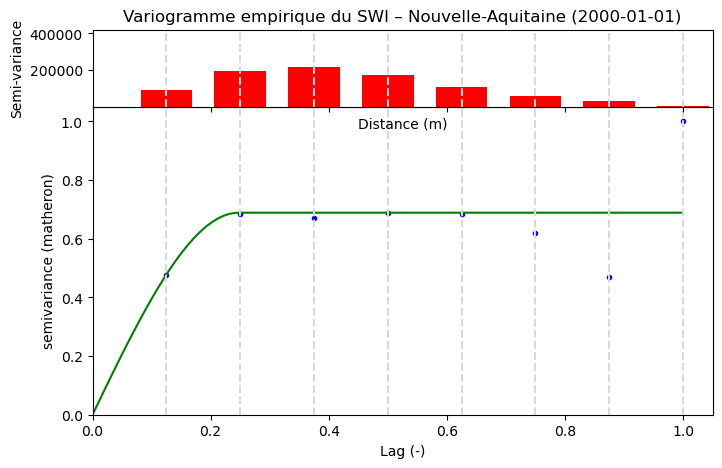

Range estimé : 1183.8551936289239
Sill : 0.004531284013557603
Nugget : 0


In [8]:
from skgstat import Variogram
import matplotlib.pyplot as plt

coords = np.vstack([gday.geometry.x.values,
                    gday.geometry.y.values]).T
values = gday["SWI"].values

V = Variogram(
    coords,
    values,
    n_lags=8,
    normalize=True,
    model="spherical"
)

fig = V.plot()
plt.title(f"Variogramme empirique du SWI – Nouvelle-Aquitaine ({date_sel.date()})")
plt.xlabel("Distance (m)")
plt.ylabel("Semi-variance")
plt.show()

print("Range estimé :", V.parameters[0])
print("Sill :", V.parameters[1])
print("Nugget :", V.parameters[2])


In [ ]:
df_naq["cell_id"] = (
    df_naq["LAMBX"].round(3).astype(str) + "_" +
    df_naq["LAMBY"].round(3).astype(str)
)


In [10]:
df_naq = df_naq.sort_values(["cell_id", "DATE_dt"]).reset_index(drop=True)

df_naq["SWI_lag1"] = (
    df_naq
    .groupby("cell_id")["SWI"]
    .shift(1)
)


In [11]:
df_model = df_naq.dropna(subset=["SWI_lag1"]).copy()
print(df_model.shape)


(9677800, 21)


In [12]:
max_rows = 300000
if len(df_model) > max_rows:
    df_model = df_model.sample(max_rows, random_state=0)
    print("Nb lignes pour le modèle :", df_model.shape[0])


Nb lignes pour le modèle : 300000


In [13]:
features = [
    "SWI_lag1",
    "PRENEI", "PRELIQ", "T", "FF", "SSWI_10J"
]

X = df_model[features]
y = df_model["SWI"]


In [14]:
cut_date = df_model["DATE_dt"].quantile(0.8)

train = df_model[df_model["DATE_dt"] <= cut_date]
test  = df_model[df_model["DATE_dt"] >  cut_date]

X_train, y_train = train[features], train["SWI"]
X_test,  y_test  = test[features],  test["SWI"]

X_train.shape, X_test.shape


((240029, 6), (59971, 6))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1,
    random_state=0
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RF spatio-temporel simple - R² : {r2:.3f}")
print(f"RF spatio-temporel simple - RMSE : {rmse:.3f}")


RF spatio-temporel simple - R² : 0.996
RF spatio-temporel simple - RMSE : 0.017


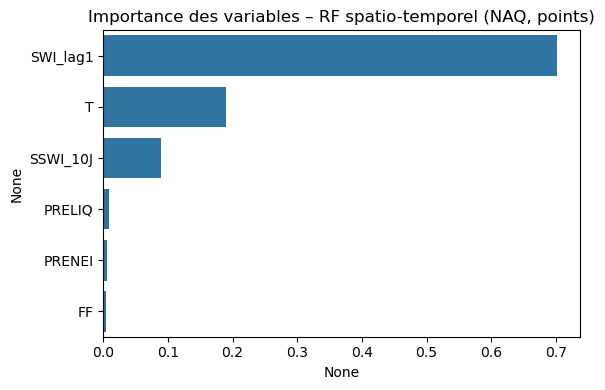

SWI_lag1    0.702235
T           0.189226
SSWI_10J    0.089080
PRELIQ      0.008360
PRENEI      0.006188
FF          0.004911
dtype: float64

In [ ]:
import seaborn as sns

imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=imp, y=imp.index)
plt.title("Importance des variables – RF spatio-temporel (NAQ, points)")
plt.tight_layout()
plt.show()

imp


## SAR / CAR

In [ ]:
import libpysal
from spreg import ML_Lag, ML_Error

# ===============================
# 1) Filtrer l'été sur toute la période
# ===============================
df_naq["DEPARTEMENT"] = df_naq["DEPARTEMENT"].astype(str)
df_naq["month_num"] = df_naq["DATE_dt"].dt.month

# Par exemple, été = juin-juillet-août
summer = df_naq[df_naq["month_num"].isin([6, 7, 8])].copy()
print("Lignes été :", summer.shape[0])

Lignes été : 2438000


In [18]:
# ===============================
# 2) Agrégation par département : SWI été moyen + covariables
# ===============================
dep_summer = (
    summer.groupby("DEPARTEMENT")
    .agg(
        SWI_summer=("SWI", "mean"),
        PRENEI_mean=("PRENEI", "mean"),
        PRELIQ_mean=("PRELIQ", "mean"),
        T_mean=("T", "mean"),
        FF_mean=("FF", "mean"),
        SSWI_10J_mean=("SSWI_10J", "mean"),
    )
    .reset_index()
)

# Centroïdes (moyenne des coords)
cent = (
    summer.groupby("DEPARTEMENT")[["LAMBX", "LAMBY"]]
    .mean()
    .reset_index()
)

dep_summer = dep_summer.merge(cent, on="DEPARTEMENT")
print(dep_summer.head())
print("Nb départements :", dep_summer.shape[0])

  DEPARTEMENT  SWI_summer  PRENEI_mean  PRELIQ_mean     T_mean   FF_mean  \
0          16    0.372990          0.0     1.953848  19.698555  2.459073   
1          17    0.370057          0.0     1.675582  19.701397  2.529834   
2          19    0.514691          0.0     2.807163  17.848347  1.699695   
3          23    0.417317          0.0     2.502221  17.753824  1.954666   
4          24    0.453891          0.0     2.055243  20.058275  1.987600   

   SSWI_10J_mean        LAMBX         LAMBY  
0       0.165042  4396.129032  20855.591398  
1       0.149855  3739.259259  20947.777778  
2      -0.038647  5683.870968  20433.225806  
3      -0.006620  5820.229885  21247.701149  
4       0.033163  4810.704225  20163.802817  
Nb départements : 12


In [19]:
# ===============================
# 3) GeoDataFrame de départements (centroïdes)
# ===============================
gdep_data = gpd.GeoDataFrame(
    dep_summer,
    geometry=gpd.points_from_xy(dep_summer["LAMBX"], dep_summer["LAMBY"]),
    crs="EPSG:2154",
).set_index("DEPARTEMENT")

In [20]:
# ===============================
# 4) Matrice de voisinage KNN (départements voisins)
# ===============================
from libpysal.weights import KNN

w = KNN.from_dataframe(gdep_data, k=4)  # 4 plus proches voisins
w.transform = "r"
print(w)
dept_order = w.id_order
gdep_data = gdep_data.loc[dept_order]

# ===============================
# 5) Préparation données pour SAR / CAR
# ===============================
y = gdep_data["SWI_summer"].values.reshape(-1, 1)
X = gdep_data[["PRENEI_mean", "PRELIQ_mean", "T_mean", "FF_mean", "SSWI_10J_mean"]].values
xnames = ["PRENEI", "PRELIQ", "T", "FF", "SSWI_10J"]

In [21]:
# --- SAR (spatial lag) ---
sar = ML_Lag(
    y, X, w=w,
    name_y="SWI_summer",
    name_x=xnames,
    name_w="KNN_dep",
    name_ds="NAQ_summer"
)
print(sar.summary)
print("SAR - pseudo R² :", sar.pr2)
print("SAR - rho (dépendance spatiale) :", sar.rho)


# --- CAR / modèle d'erreur spatiale ---
car = ML_Error(
    y, X, w=w,
    name_y="SWI_summer",
    name_x=xnames,
    name_w="KNN_dep",
    name_ds="NAQ_summer"
)
rho = float(getattr(sar, "rho"))
lam = float(getattr(car, "lam", getattr(car, "lambda1", getattr(car, "lambda", float("nan")))))

print(f"SAR - rho (dépendance spatiale) : {rho:.3f}")
print(f"CAR - lambda (erreur spatiale) : {lam:.3f}")


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :  NAQ_summer
Weights matrix      :     KNN_dep
Dependent Variable  :  SWI_summer                Number of Observations:          12
Mean dependent var  :      0.4280                Number of Variables   :           7
S.D. dependent var  :      0.0808                Degrees of Freedom    :           5
Pseudo R-squared    :      0.9264
Spatial Pseudo R-squared:  0.9225
Log likelihood      :     29.3321
Sigma-square ML     :      0.0004                Akaike info criterion :     -44.664
S.E of regression   :      0.0210                Schwarz criterion     :     -41.270

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

In [22]:
from esda.moran import Moran

res_sar = sar.u.flatten()
mi_res = Moran(res_sar, w)

print("Moran I des résidus SAR :", mi_res.I)
print("p-valeur :", mi_res.p_sim)


Moran I des résidus SAR : -0.22192512963782912
p-valeur : 0.165


## Kriging

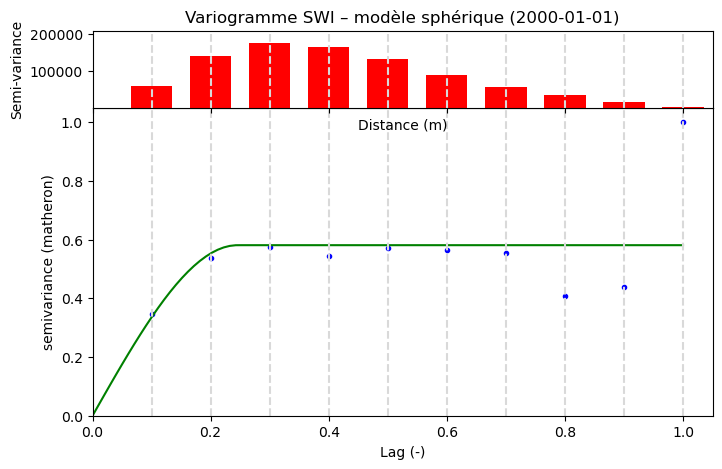

Param sphérique (range, sill, nugget) : [np.float64(1175.6712502810176), np.float64(0.004635203267090543), 0]


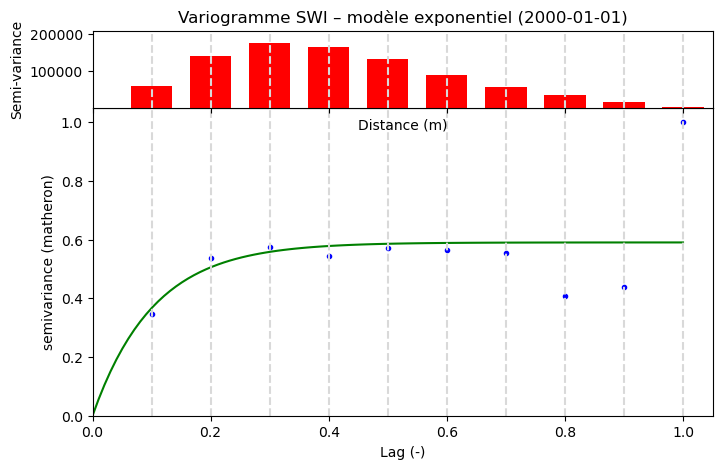

Param exponentiel (range, sill, nugget) : [np.float64(1481.0546217815458), np.float64(0.00471005989915129), 0]


In [ ]:
from skgstat import Variogram

coords = np.vstack([gday.geometry.x.values,
                    gday.geometry.y.values]).T
values = gday["SWI"].values

# Modèle sphérique
V_sph = Variogram(
    coords,
    values,
    n_lags=10,
    model="spherical",
    normalize=True
)

fig = V_sph.plot()
plt.title(f"Variogramme SWI – modèle sphérique ({date_sel.date()})")
plt.xlabel("Distance (m)")
plt.ylabel("Semi-variance")
plt.show()
print("Param sphérique (range, sill, nugget) :", V_sph.parameters)

# Modèle exponentiel
V_exp = Variogram(
    coords,
    values,
    n_lags=10,
    model="exponential",
    normalize=True
)

fig = V_exp.plot()
plt.title(f"Variogramme SWI – modèle exponentiel ({date_sel.date()})")
plt.xlabel("Distance (m)")
plt.ylabel("Semi-variance")
plt.show()
print("Param exponentiel (range, sill, nugget) :", V_exp.parameters)


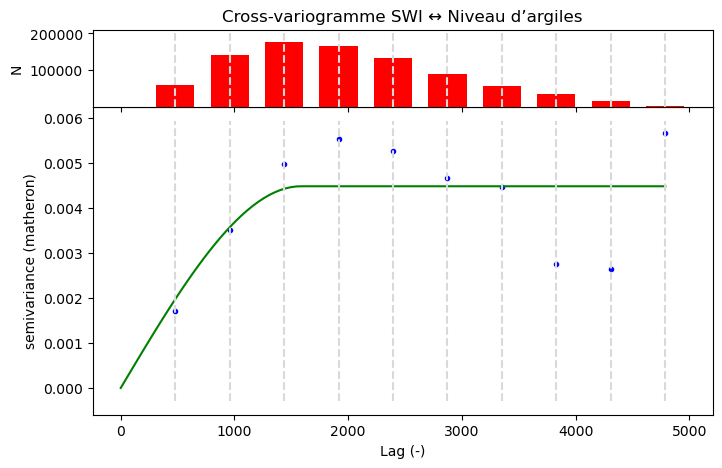

In [24]:
clay = gday["NIVEAU"].values

coords2 = coords.copy()

V_cross = Variogram(
    coords2,
    np.vstack([values, clay]).T,
    model='spherical',
    cross=True
)

V_cross.plot()
plt.title("Cross-variogramme SWI ↔ Niveau d’argiles")
plt.show()


In [25]:
from pykrige.ok import OrdinaryKriging

x = gday.geometry.x.values
y = gday.geometry.y.values
z = gday["SWI"].values

# Grille Lambert-93 couvrant la NAQ
xmin, ymin, xmax, ymax = gday.total_bounds
nx, ny = 80, 80
gridx = np.linspace(xmin, xmax, nx)
gridy = np.linspace(ymin, ymax, ny)

# --- Kriging sphérique ---
ok_sph = OrdinaryKriging(
    x, y, z,
    variogram_model="spherical",
    verbose=False,
    enable_plotting=False,
)
z_sph, ss_sph = ok_sph.execute("grid", gridx, gridy)

# --- Kriging exponentiel ---
ok_exp = OrdinaryKriging(
    x, y, z,
    variogram_model="exponential",
    verbose=False,
    enable_plotting=False,
)
z_exp, ss_exp = ok_exp.execute("grid", gridx, gridy)


In [26]:
from pykrige.uk import UniversalKriging

uk = UniversalKriging(
    x, y, z,
    variogram_model="spherical",
    drift_terms=["regional_linear"],  # tendance linéaire en x,y
)

z_uk, ss_uk = uk.execute("grid", gridx, gridy)


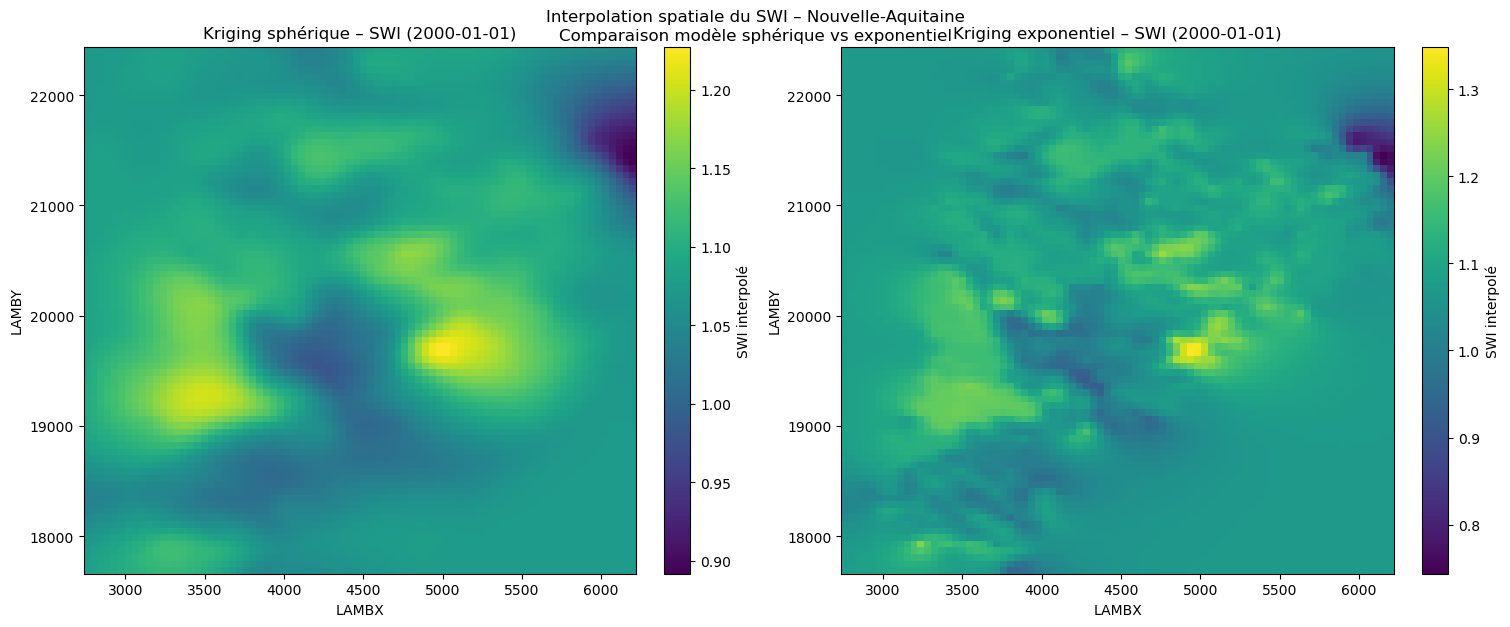

In [27]:
Xg, Yg = np.meshgrid(gridx, gridy)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

im0 = axes[0].pcolormesh(Xg, Yg, z_sph, shading="auto")
axes[0].set_title(f"Kriging sphérique – SWI ({date_sel.date()})")
axes[0].set_xlabel("LAMBX")
axes[0].set_ylabel("LAMBY")
fig.colorbar(im0, ax=axes[0], label="SWI interpolé")

im1 = axes[1].pcolormesh(Xg, Yg, z_exp, shading="auto")
axes[1].set_title(f"Kriging exponentiel – SWI ({date_sel.date()})")
axes[1].set_xlabel("LAMBX")
axes[1].set_ylabel("LAMBY")
fig.colorbar(im1, ax=axes[1], label="SWI interpolé")

plt.suptitle("Interpolation spatiale du SWI – Nouvelle-Aquitaine\nComparaison modèle sphérique vs exponentiel", y=1.02)
plt.show()


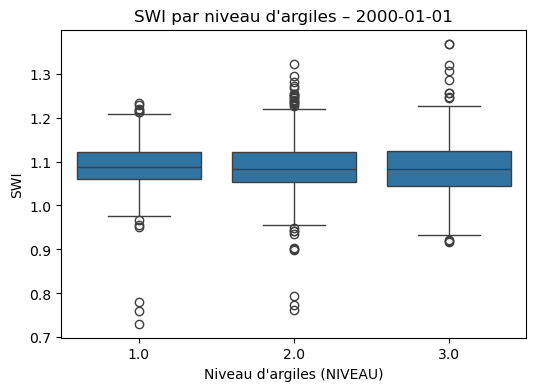

In [28]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_day, x="NIVEAU", y="SWI")
plt.title(f"SWI par niveau d'argiles – {date_sel.date()}")
plt.xlabel("Niveau d'argiles (NIVEAU)")
plt.ylabel("SWI")
plt.show()


In [29]:
corr_clay = df_day[["SWI", "dist_argiles_m"]].corr().iloc[0, 1]
print("Corrélation SWI / distance aux argiles (m) :", corr_clay)


Corrélation SWI / distance aux argiles (m) : 0.2625791119696678


In [ ]:

# On part de df_naq déjà en mémoire
data = df_naq.copy()

print("Colonnes df_naq :", data.columns.tolist())

# ===== 1) Trouver la bonne colonne de date =====
date_col = None

if "DATE" in data.columns:
    date_col = "DATE"
elif "DATE_dt" in data.columns:
    date_col = "DATE_dt"
else:
    # Si aucune des deux n'existe, on cherche une colonne déjà en datetime
    dt_cols = data.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
    if len(dt_cols) > 0:
        date_col = dt_cols[0]  # on prend la première
    else:
        raise ValueError(
            f"Aucune colonne de date trouvée dans df_naq. Colonnes = {data.columns.tolist()}"
        )

print("Colonne de date utilisée :", date_col)

# On crée une colonne standardisée 'DATE'
data["DATE"] = pd.to_datetime(data[date_col])

# ===== 2) Tri spatio-temporel =====
for col in ["DEPARTEMENT", "COMMUNE"]:
    if col in data.columns:
        data[col] = data[col].astype(str)
    else:
        raise ValueError(f"Colonne manquante : {col}")

data = data.sort_values(["DEPARTEMENT", "COMMUNE", "DATE"])

# ===== 3) Lag temporel SWI(t-1) =====
data["SWI_lag1"] = data.groupby(["DEPARTEMENT", "COMMUNE"])["SWI"].shift(1)

print(data[["DEPARTEMENT","COMMUNE","DATE","SWI","SWI_lag1"]].head())


Colonnes df_naq : ['LAMBX', 'LAMBY', 'DATE', 'PRENEI', 'PRELIQ', 'T', 'FF', 'SWI', 'SSWI_10J', 'ALEA', 'NIVEAU', 'DPT', 'ARGILES_FROM', 'dist_argiles_m', 'COMMUNE', 'DEPARTEMENT', 'REGION', 'MONTH', 'DATE_dt', 'cell_id', 'SWI_lag1', 'month_num']
Colonne de date utilisée : DATE
        DEPARTEMENT COMMUNE       DATE    SWI  SWI_lag1
6443010          16  Alloue 2000-01-01  1.091       NaN
6443011          16  Alloue 2000-01-02  1.071     1.091
6443012          16  Alloue 2000-01-03  1.051     1.071
6443013          16  Alloue 2000-01-04  1.033     1.051
6443014          16  Alloue 2000-01-05  1.018     1.033


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ==========================
# 1) Jeu de données propre
# ==========================
data = df_naq.copy()   # juste pour être sûr du nom

features = [
    "SWI_lag1",
    "PRENEI", "PRELIQ", "T", "FF",
    "NIVEAU", "dist_argiles_m",
    "LAMBX", "LAMBY",
]

# On garde seulement les features qui existent vraiment
features = [f for f in features if f in data.columns]
print("Variables explicatives utilisées :", features)

# On enlève toutes les lignes avec NaN dans SWI, SWI_lag1 ou une feature
df_model = data.dropna(subset=["SWI", "SWI_lag1"] + features).copy()
print("Shape df_model après dropna :", df_model.shape)
print("Colonnes df_model :", df_model.columns.tolist())

# X et y pour le modèle
X_full = df_model[features]
y_full = df_model["SWI"]

# IMPORTANT : le split conserve les index -> on pourra revenir à df_model
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=0
)


Variables explicatives utilisées : ['SWI_lag1', 'PRENEI', 'PRELIQ', 'T', 'FF', 'NIVEAU', 'dist_argiles_m', 'LAMBX', 'LAMBY']
Shape df_model après dropna : (3418272, 22)
Colonnes df_model : ['LAMBX', 'LAMBY', 'DATE', 'PRENEI', 'PRELIQ', 'T', 'FF', 'SWI', 'SSWI_10J', 'ALEA', 'NIVEAU', 'DPT', 'ARGILES_FROM', 'dist_argiles_m', 'COMMUNE', 'DEPARTEMENT', 'REGION', 'MONTH', 'DATE_dt', 'cell_id', 'SWI_lag1', 'month_num']


In [ ]:
# ==========================
# 2) Modèle linéaire
# ==========================
from sklearn.metrics import r2_score, mean_squared_error

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

print("\n=== Modèle ARX linéaire spatio-temporel ===")
print(f"R²   : {r2_lin:.3f}")
print(f"RMSE : {rmse_lin:.3f}")


=== Modèle ARX linéaire spatio-temporel ===
R²   : 0.997
RMSE : 0.016


In [33]:
# ==========================
# 3) Random Forest spatio-temporel
# ==========================
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=0,
    n_jobs=-1,
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

In [34]:

print("\n=== Random Forest spatio-temporel ===")
print(f"R²   : {r2_rf:.3f}")
print(f"RMSE : {rmse_rf:.3f}")


=== Random Forest spatio-temporel ===
R²   : 0.998
RMSE : 0.014


In [35]:
# df_model vient de :
# df_model = data.dropna(subset=["SWI", "SWI_lag1"] + features).copy()

df_test_full = df_model.loc[X_test.index].copy()

df_test_full["y_true"] = y_test.values
df_test_full["y_pred_lin"] = y_pred_lin
df_test_full["y_pred_rf"] = y_pred_rf   # si tu veux aussi RF

# S'assurer que la date est bien en datetime
df_test_full["DATE"] = pd.to_datetime(df_test_full["DATE"])


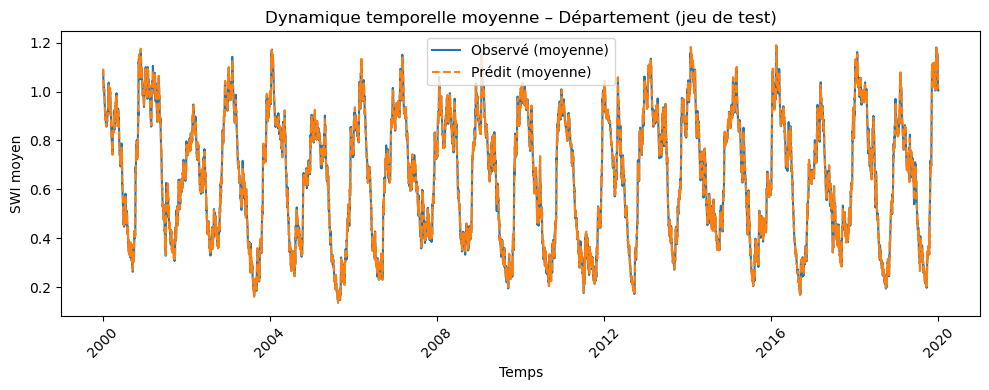

In [36]:
df_t = (
    df_test_full
    .groupby("DATE")[["y_true", "y_pred_lin"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(df_t["DATE"], df_t["y_true"], label="Observé (moyenne)")
plt.plot(df_t["DATE"], df_t["y_pred_lin"], "--", label="Prédit (moyenne)")

plt.xlabel("Temps")
plt.ylabel("SWI moyen")
plt.title("Dynamique temporelle moyenne – Département (jeu de test)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## 4. Quantification de l'incertitude

In [37]:
# DataFrame test complet : on revient aux lignes originales
df_test_full = df_model.loc[X_test.index].copy()

df_test_full["y_true"] = y_test.values
df_test_full["y_pred_lin"] = y_pred_lin
df_test_full["y_pred_rf"] = y_pred_rf

# Assurer que la date est bien au bon format
df_test_full["DATE"] = pd.to_datetime(df_test_full["DATE"])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# ====================================
# 4) Conformal Prediction (CQR)
# ====================================

# On repart de ton X_train / y_train existant
X_train_cq, X_cal, y_train_cq, y_cal = train_test_split(
    X_train, y_train,
    test_size=0.25,     # 25% du train pour la calibration conformale
    random_state=0
)

print("Taille train CQR :", X_train_cq.shape)
print("Taille cal       :", X_cal.shape)
print("Taille test      :", X_test.shape)


Taille train CQR : (2050962, 9)
Taille cal       : (683655, 9)
Taille test      : (683655, 9)


In [39]:
alpha_low = 0.05   # quantile bas
alpha_high = 0.95  # quantile haut

gbr_low = GradientBoostingRegressor(
    loss="quantile",
    alpha=alpha_low,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    random_state=0,
)

gbr_high = GradientBoostingRegressor(
    loss="quantile",
    alpha=alpha_high,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    random_state=0,
)

# Entraînement sur le sous-ensemble train_cq
gbr_low.fit(X_train_cq, y_train_cq)
gbr_high.fit(X_train_cq, y_train_cq)

print("Modèles de quantiles (5% / 95%) entraînés.")


Modèles de quantiles (5% / 95%) entraînés.


In [40]:
# Prédictions quantiles sur le set de calibration
q_low_cal = gbr_low.predict(X_cal)
q_high_cal = gbr_high.predict(X_cal)

# Scores de non-conformité CQR :
# s_i = max(q_low(x_i) - y_i, y_i - q_high(x_i))
scores = np.maximum(q_low_cal - y_cal, y_cal - q_high_cal)

alpha = 0.10  # niveau de risque cible (→ 90% de couverture théorique)

n_cal = len(scores)
q_hat = np.quantile(
    scores,
    q=np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
)

print(f"Quantile de calibration q_hat = {q_hat:.4f}")


Quantile de calibration q_hat = -0.0006


In [41]:
from sklearn.metrics import r2_score, mean_squared_error

# Prédictions quantiles sur le test
q_low_test = gbr_low.predict(X_test)
q_high_test = gbr_high.predict(X_test)

# Intervalles conformes
L_cqr = q_low_test - q_hat
U_cqr = q_high_test + q_hat

# Point estimate = milieu de l'intervalle (optionnel mais pratique)
y_pred_cqr = 0.5 * (L_cqr + U_cqr)

# Couverture empirique globale
covered = (y_test >= L_cqr) & (y_test <= U_cqr)
coverage_empirical = covered.mean()

# Largeur moyenne
width_mean = (U_cqr - L_cqr).mean()

# Quelques métriques sur la prédiction centrale
r2_cqr = r2_score(y_test, y_pred_cqr)
rmse_cqr = np.sqrt(mean_squared_error(y_test, y_pred_cqr))

print("\n=== Conformal Prediction (CQR) – niveau 90% ===")
print(f"Couverture empirique globale : {coverage_empirical*100:.2f} %")
print(f"Largeur moyenne des intervalles : {width_mean:.4f}")
print(f"R² (milieu intervalle) : {r2_cqr:.3f}")
print(f"RMSE (milieu intervalle) : {rmse_cqr:.3f}")



=== Conformal Prediction (CQR) – niveau 90% ===
Couverture empirique globale : 89.96 %
Largeur moyenne des intervalles : 0.0562
R² (milieu intervalle) : 0.989
RMSE (milieu intervalle) : 0.029


In [42]:
# Ajout des colonnes CQR dans le DF complet de test
df_test_full["y_pred_cqr"] = y_pred_cqr
df_test_full["L_cqr"] = L_cqr
df_test_full["U_cqr"] = U_cqr

df_test_full["covered_cqr"] = (
    (df_test_full["y_true"] >= df_test_full["L_cqr"]) &
    (df_test_full["y_true"] <= df_test_full["U_cqr"])
).astype(int)


In [43]:
coverage_by_month = (
    df_test_full
    .groupby("month_num")["covered_cqr"]
    .mean()
    .sort_index()
)

print("\nCouverture empirique par mois (CQR 90%) :")
print((coverage_by_month * 100).round(2))



Couverture empirique par mois (CQR 90%) :
month_num
1     94.03
2     95.35
3     93.05
4     87.22
5     85.36
6     85.69
7     86.85
8     86.17
9     89.53
10    90.34
11    92.51
12    93.71
Name: covered_cqr, dtype: float64


In [44]:
coverage_by_level = (
    df_test_full
    .groupby("NIVEAU")["covered_cqr"]
    .mean()
    .sort_index()
)

print("\nCouverture empirique par niveau de sécheresse NIVEAU :")
print((coverage_by_level * 100).round(2))



Couverture empirique par niveau de sécheresse NIVEAU :
NIVEAU
1.0    90.98
2.0    89.38
3.0    90.31
Name: covered_cqr, dtype: float64


In [ ]:

# Largeur de l'intervalle pour chaque observation
df_test_full["width_cqr"] = df_test_full["U_cqr"] - df_test_full["L_cqr"]

# GeoDataFrame de points (Lambert 93)
gdf_test = gpd.GeoDataFrame(
    df_test_full.copy(),
    geometry=gpd.points_from_xy(df_test_full["LAMBX"], df_test_full["LAMBY"]),
    crs="EPSG:2154"   # Lambert-93 normalement
)


In [46]:
# Résumé par maille spatiale
gdf_cells = (
    gdf_test
    .groupby("cell_id")
    .agg(
        width_mean=("width_cqr", "mean"),
        coverage_mean=("covered_cqr", "mean"),
        swi_true_mean=("y_true", "mean"),
        swi_pred_mean=("y_pred_cqr", "mean"),
        geometry=("geometry", "first"),
        DEPARTEMENT=("DEPARTEMENT", "first"),
    )
    .reset_index()
)

gdf_cells = gpd.GeoDataFrame(gdf_cells, geometry="geometry", crs=gdf_test.crs)


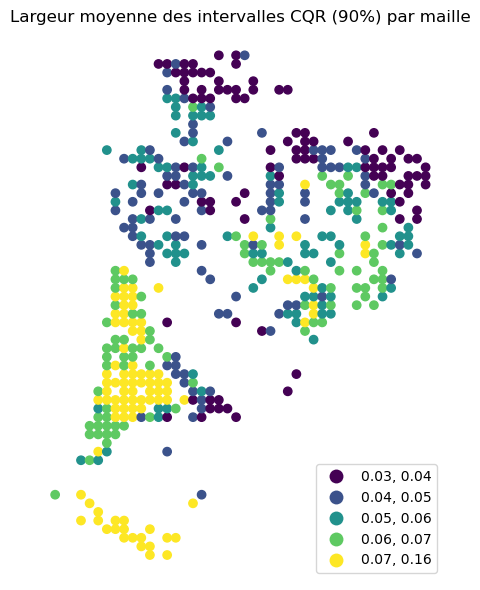

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells.plot(
    column="width_mean",
    ax=ax,
    legend=True,
    scheme="quantiles",   # si dispo (requires mapclassify)
    k=5,
)
ax.set_title("Largeur moyenne des intervalles CQR (90%) par maille")
ax.set_axis_off()
plt.tight_layout()
plt.show()


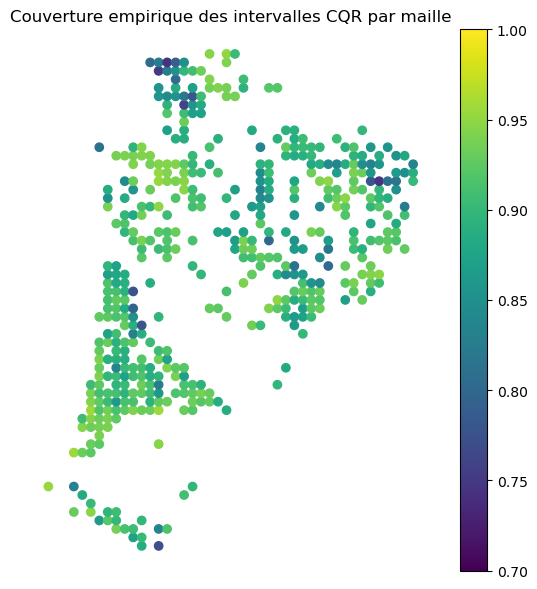

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells.plot(
    column="coverage_mean",
    ax=ax,
    legend=True,
    vmin=0.7, vmax=1.0,   # pour voir où ça décroche vs 90%
)
ax.set_title("Couverture empirique des intervalles CQR par maille")
ax.set_axis_off()
plt.tight_layout()
plt.show()


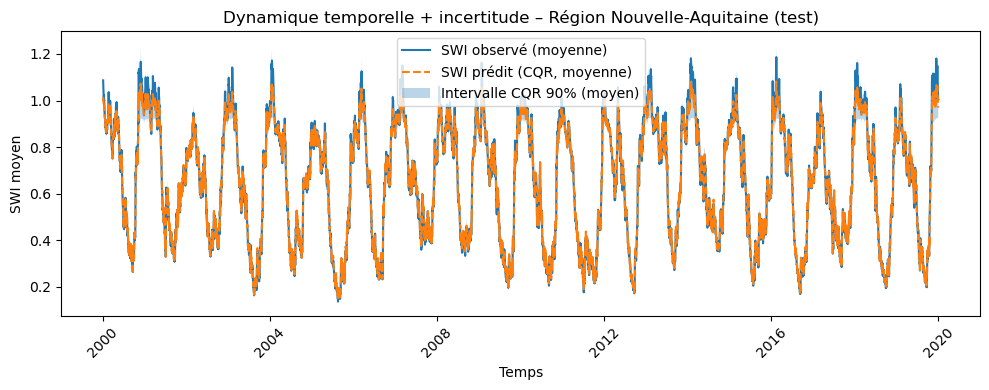

In [49]:
df_t = (
    df_test_full
    .groupby("DATE")[["y_true", "y_pred_cqr", "L_cqr", "U_cqr"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(df_t["DATE"], df_t["y_true"], label="SWI observé (moyenne)")
plt.plot(df_t["DATE"], df_t["y_pred_cqr"], "--", label="SWI prédit (CQR, moyenne)")
plt.fill_between(df_t["DATE"], df_t["L_cqr"], df_t["U_cqr"],
                 alpha=0.3, label="Intervalle CQR 90% (moyen)")
plt.xlabel("Temps")
plt.ylabel("SWI moyen")
plt.title("Dynamique temporelle + incertitude – Région Nouvelle-Aquitaine (test)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

gdf_test = gpd.GeoDataFrame(
    df_test_full.copy(),
    geometry=gpd.points_from_xy(df_test_full["LAMBX"], df_test_full["LAMBY"]),
    crs="EPSG:2154"
)


In [ ]:

gdf_test = gpd.GeoDataFrame(
    df_test_full.copy(),
    geometry=gpd.points_from_xy(df_test_full["LAMBX"], df_test_full["LAMBY"]),
    crs="EPSG:2154"
)

# Largeur de l'intervalle CQR
gdf_test["width_cqr"] = gdf_test["U_cqr"] - gdf_test["L_cqr"]

# Erreur de prédiction (milieu de l'intervalle CQR)
gdf_test["error"] = gdf_test["y_pred_cqr"] - gdf_test["y_true"]
gdf_test["error_abs"] = gdf_test["error"].abs()
gdf_test["error_sq"] = gdf_test["error"]**2

# Si jamais covered_cqr n'est pas encore créé dans df_test_full :
gdf_test["covered_cqr"] = (
    (gdf_test["y_true"] >= gdf_test["L_cqr"]) &
    (gdf_test["y_true"] <= gdf_test["U_cqr"])
).astype(int)


In [52]:
gdf_cells = (
    gdf_test
    .groupby("cell_id")
    .agg(
        width_mean   = ("width_cqr", "mean"),
        coverage_mean= ("covered_cqr", "mean"),
        mae          = ("error_abs", "mean"),
        rmse         = ("error_sq", lambda x: np.sqrt(x.mean())),
        bias         = ("error", "mean"),
        swi_true_mean= ("y_true", "mean"),
        swi_pred_mean= ("y_pred_cqr", "mean"),
        DEPARTEMENT  = ("DEPARTEMENT", "first"),
        geometry     = ("geometry", "first"),
    )
    .reset_index()
)

gdf_cells = gpd.GeoDataFrame(gdf_cells, geometry="geometry", crs=gdf_test.crs)


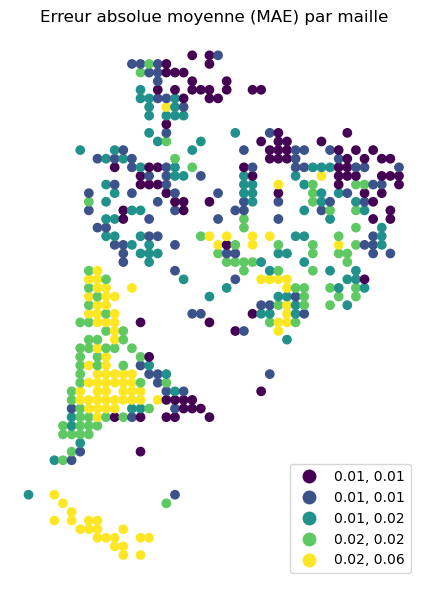

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells.plot(
    column="mae",
    ax=ax,
    legend=True,
    scheme="quantiles",  # tu peux enlever si mapclassify n'est pas installé
    k=5,
)
ax.set_title("Erreur absolue moyenne (MAE) par maille")
ax.set_axis_off()
plt.tight_layout()
plt.show()


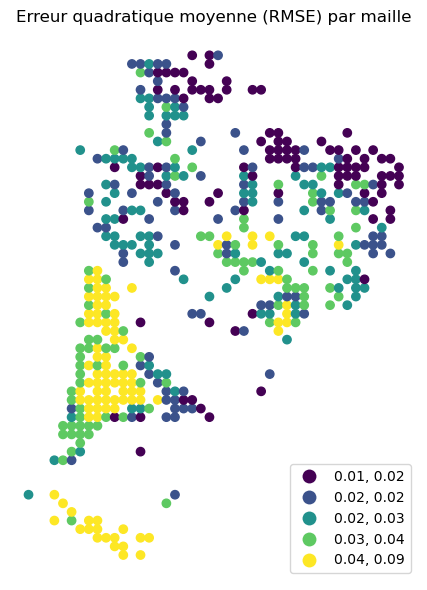

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells.plot(
    column="rmse",
    ax=ax,
    legend=True,
    scheme="quantiles",
    k=5,
)
ax.set_title("Erreur quadratique moyenne (RMSE) par maille")
ax.set_axis_off()
plt.tight_layout()
plt.show()


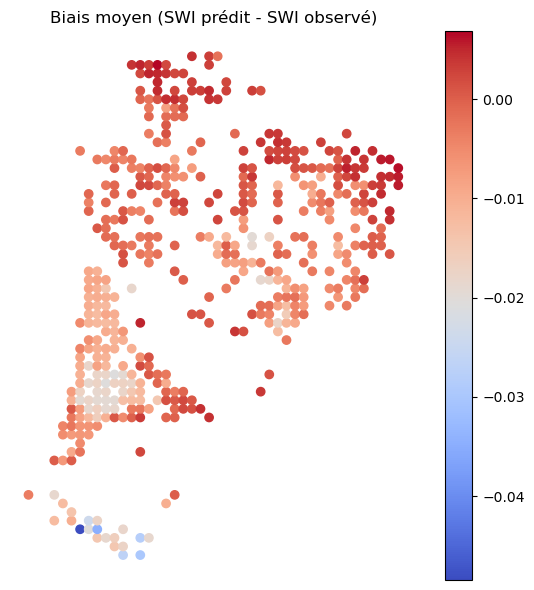

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells.plot(
    column="bias",
    ax=ax,
    legend=True,
    cmap="coolwarm",   
)
ax.set_title("Biais moyen (SWI prédit - SWI observé)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


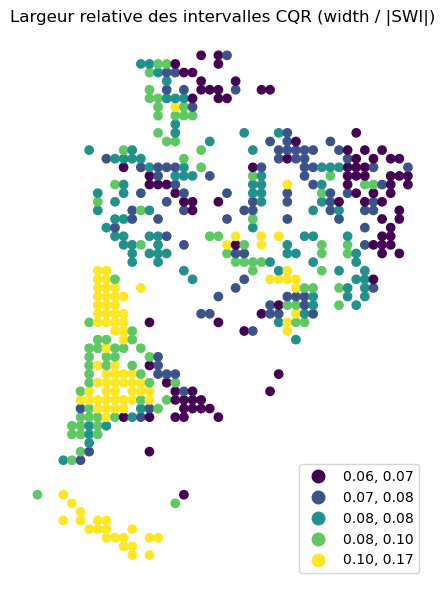

In [56]:
gdf_cells["rel_width"] = gdf_cells["width_mean"] / gdf_cells["swi_true_mean"].abs()

fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells.plot(
    column="rel_width",
    ax=ax,
    legend=True,
    scheme="quantiles",
    k=5,
)
ax.set_title("Largeur relative des intervalles CQR (width / |SWI|)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [57]:
# Seuils par quantiles
thr_swi = gdf_cells["swi_true_mean"].quantile(0.25)    # SWI bas = sécheresse
thr_width = gdf_cells["width_mean"].quantile(0.75)     # incertitude élevée

def classify_row(row):
    dry = row["swi_true_mean"] <= thr_swi
    uncertain = row["width_mean"] >= thr_width
    if dry and uncertain:
        return "1. Sec & très incertain"
    elif dry and not uncertain:
        return "2. Sec & assez certain"
    elif not dry and uncertain:
        return "3. Humide & incertain"
    else:
        return "4. Humide & certain"

gdf_cells["class_risk_unc"] = gdf_cells.apply(classify_row, axis=1)


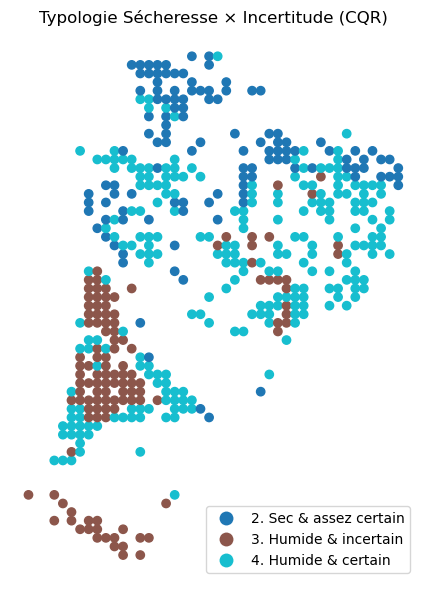

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells.plot(
    column="class_risk_unc",
    ax=ax,
    legend=True,
    categorical=True,
)
ax.set_title("Typologie Sécheresse × Incertitude (CQR)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path

# --- chemins (robuste) ---
ROOT = Path.cwd()
while not (ROOT / "data").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

DATA_DB = ROOT / "data" / "database"
DATA_PROC = ROOT / "data" / "processed"

print("ROOT    =", ROOT)
print("DATA_DB =", DATA_DB)

# --- charge la base modélisation (celle de ta collègue) ---
path_mod = DATA_DB / "base_dep_brgm_alea_dominante_modelisation.parquet"
dfm = pd.read_parquet(path_mod)

print("\n✅ Chargée:", path_mod)
print("Shape:", dfm.shape)

# --- aperçu ---
print("\nColonnes:")
print(dfm.columns.tolist())

print("\nDtypes:")
print(dfm.dtypes)

print("\nHead:")
display(dfm.head(10))

# --- NA / doublons ---
na_rate = (dfm.isna().mean().sort_values(ascending=False) * 100).round(2)
print("\n% NA par colonne (top 15):")
print(na_rate.head(15))

# doublons éventuels
for k in ["code_insee", "DEPARTEMENT", "DPT", "dep", "code_dep", "code_insee_du_departement"]:
    if k in dfm.columns:
        print(f"\nDoublons sur {k} :", dfm.duplicated(k).sum())
        print("Nb uniques:", dfm[k].nunique())

# --- devine le "niveau" de la base (commune vs département) ---
level = None
if "code_insee" in dfm.columns:
    level = "COMMUNE (code_insee présent)"
elif any(c in dfm.columns for c in ["DEPARTEMENT","DPT","dep","code_dep","code_insee_du_departement"]):
    level = "DEPARTEMENT (code dep présent)"
else:
    level = "INCONNU (pas de clé évidente)"

print("\n📌 Niveau détecté:", level)

# --- stats rapides sur les colonnes numériques (si petites) ---
num_cols = dfm.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    print("\nStats numériques (describe):")
    display(dfm[num_cols].describe().T)


ROOT    = /Users/larbi/Documents/PROJET-ML-FOR-CLIMATE-RISK
DATA_DB = /Users/larbi/Documents/PROJET-ML-FOR-CLIMATE-RISK/data/database

✅ Chargée: /Users/larbi/Documents/PROJET-ML-FOR-CLIMATE-RISK/data/database/base_dep_brgm_alea_dominante_modelisation.parquet
Shape: (12, 2)

Colonnes:
['DEPARTEMENT', 'ALEA_dom']

Dtypes:
DEPARTEMENT    object
ALEA_dom       object
dtype: object

Head:


,DEPARTEMENT,ALEA_dom
0,16,Moyen
1,17,Fort
2,19,Faible
3,23,Moyen
4,24,Fort
5,33,Moyen
6,40,Faible
7,47,Fort
8,64,Moyen
9,79,Moyen



% NA par colonne (top 15):
DEPARTEMENT    0.0
ALEA_dom       0.0
dtype: float64

Doublons sur DEPARTEMENT : 0
Nb uniques: 12

📌 Niveau détecté: DEPARTEMENT (code dep présent)


In [ ]:
from pathlib import Path

# =========================
# 0) Paths
# =========================
ROOT = Path.cwd()
while not (ROOT / "data").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent
DATA_DB = ROOT / "data" / "database"

# =========================
# 1) Charge la table "alea dominante" par département
# =========================
dep_tbl = pd.read_parquet(DATA_DB / "base_dep_brgm_alea_dominante_modelisation.parquet").copy()

# Normalisation clé département (robuste)
def norm_dep(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s = s.replace(".0", "")  
    s = s.upper()
    
    if s.isdigit():
        return s.zfill(2)
    return s

dep_tbl["dep_key"] = dep_tbl["DEPARTEMENT"].map(norm_dep)
dep_tbl = dep_tbl.drop_duplicates("dep_key")[["dep_key", "ALEA_dom"]]

print("dep_tbl:", dep_tbl.shape)
display(dep_tbl.head())

# =========================
# 2) Ajoute ALEA_dom dans la base NAQ (df_model ou df_naq)
# =========================
data = df_model.copy()   

# Trouve la colonne département dans NAQ
dep_col = None
for c in ["DEPARTEMENT", "DPT", "DEP", "departement", "dpt"]:
    if c in data.columns:
        dep_col = c
        break

print("dep_col utilisé =", dep_col)

data["dep_key"] = data[dep_col].map(norm_dep)

# Merge (left join) : on conserve toutes les lignes NAQ
data = data.merge(dep_tbl, on="dep_key", how="left")

# Check qualité merge
miss = data["ALEA_dom"].isna().mean()
print(f"% ALEA_dom manquant après merge: {miss*100:.2f}%")
print("Valeurs ALEA_dom:", data["ALEA_dom"].value_counts(dropna=False))

# ✅ ta base NAQ enrichie est prête ici :
df_model_plus = data
print(data)


dep_tbl: (12, 2)


,dep_key,ALEA_dom
0,16,Moyen
1,17,Fort
2,19,Faible
3,23,Moyen
4,24,Fort


dep_col utilisé = DEPARTEMENT
% ALEA_dom manquant après merge: 0.00%
Valeurs ALEA_dom: ALEA_dom
Moyen     1314720
Faible    1051776
Fort      1051776
Name: count, dtype: int64
         LAMBX  LAMBY       DATE  PRENEI  PRELIQ    T   FF    SWI  SSWI_10J  \
0         2760  18250 2000-01-02     0.0     0.2  9.0  1.5  1.009     0.536   
1         2760  18250 2000-01-03     0.0     0.2  7.6  2.2  0.994     0.562   
2         2760  18250 2000-01-04     0.0     0.0  9.4  1.6  0.979     0.573   
3         2760  18250 2000-01-05     0.0     0.0  9.7  2.5  0.968     0.572   
4         2760  18250 2000-01-06     0.0     0.0  9.9  2.5  0.956     0.496   
...        ...    ...        ...     ...     ...  ...  ...    ...       ...   
3418267   6200  21290 2019-12-27     0.0     5.6  7.1  3.4  0.935     1.367   
3418268   6200  21290 2019-12-28     0.0     0.0  4.5  2.4  0.930     1.377   
3418269   6200  21290 2019-12-29     0.1     0.1  0.4  0.8  0.922     1.380   
3418270   6200  21290 2019-12-30  

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# ============
# 0) Base prête
# ============
df = df_model_plus.copy()

# ============
# 1) Colonnes clés
# ============
target = "SWI"
assert target in df.columns, f"Target '{target}' introuvable. Colonnes: {df.columns.tolist()}"

xcol = "LAMBX" if "LAMBX" in df.columns else None
ycol = "LAMBY" if "LAMBY" in df.columns else None

# ============
# 2) Features
# ============
base_features = [
    "SWI_lag1",
    "PRENEI", "PRELIQ", "T", "FF",
    "SSWI_10J",
    "NIVEAU", "ALEA",
    "dist_argiles_m",
]

if xcol and ycol:
    base_features += [xcol, ycol]

base_features = [c for c in base_features if c in df.columns]
plus_features = base_features + (["ALEA_dom"] if "ALEA_dom" in df.columns else [])
plus_features = [c for c in plus_features if c in df.columns]

print("Base features:", base_features)
print("Plus features:", plus_features)

# ============
# 3) Préparation commune (split + preprocess + métriques)
# ============
def _prepare_data(df, features):
    dfM = df[[target] + features].dropna().copy()

    X = dfM[features]
    y = dfM[target]

    cat_cols = [c for c in features if (dfM[c].dtype == "object") or (str(dfM[c].dtype).startswith("category"))]
    num_cols = [c for c in features if c not in cat_cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )

    return dfM, X_train, X_test, y_train, y_test, pre

def _eval(pipe, X_test, y_test, label, n, feats):
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"[{label}] R2={r2:.3f} | RMSE={rmse:.3f} | n={n:,} | feats={feats}")
    return r2, rmse

# ============================================================
# 4) Modèle 1 : Random Forest (spatio-temp)
# ============================================================
def fit_eval_rf(df, features, label="RF"):
    dfM, X_train, X_test, y_train, y_test, pre = _prepare_data(df, features)

    est = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        random_state=0,
        n_jobs=-1
    )

    pipe = Pipeline(steps=[("prep", pre), ("est", est)])
    pipe.fit(X_train, y_train)

    r2, rmse = _eval(pipe, X_test, y_test, label, n=len(dfM), feats=len(features))
    return r2, rmse, pipe


Base features: ['SWI_lag1', 'PRENEI', 'PRELIQ', 'T', 'FF', 'SSWI_10J', 'NIVEAU', 'ALEA', 'dist_argiles_m', 'LAMBX', 'LAMBY']
Plus features: ['SWI_lag1', 'PRENEI', 'PRELIQ', 'T', 'FF', 'SSWI_10J', 'NIVEAU', 'ALEA', 'dist_argiles_m', 'LAMBX', 'LAMBY', 'ALEA_dom']


In [64]:
# ============================================================
# 5) Modèle 2 : ARX linéaire (LinearRegression spatio-temp)
# ============================================================
def fit_eval_arx(df, features, label="ARX lin"):
    dfM, X_train, X_test, y_train, y_test, pre = _prepare_data(df, features)

    est = LinearRegression()

    pipe = Pipeline(steps=[("prep", pre), ("est", est)])
    pipe.fit(X_train, y_train)

    r2, rmse = _eval(pipe, X_test, y_test, label, n=len(dfM), feats=len(features))
    return r2, rmse, pipe

# ============
# 6) Exécutions : RF puis ARX, BASE vs +ALEA_dom
# ============
print("\n--- RANDOM FOREST ---")
# r2_rf0, rmse_rf0, rf0 = fit_eval_rf(df, base_features, label="RF (BASE)")
r2_rf1, rmse_rf1, rf1 = fit_eval_rf(df, plus_features, label="RF (+ALEA_dom)")

print("Delta RF:")
print(r2_rf1)



--- RANDOM FOREST ---
[RF (+ALEA_dom)] R2=0.998 | RMSE=0.014 | n=3,418,272 | feats=12
Delta RF:
0.997725939162656


In [69]:
print("\n--- ARX LINÉAIRE ---")
# r2_arx0, rmse_arx0, arx0 = fit_eval_arx(df, base_features, label="ARX (BASE)")
r2_arx1, rmse_arx1, arx1 = fit_eval_arx(df, plus_features, label="ARX (+ALEA_dom)")

print("R^2 / RMSE")
print(r2_arx1)
print(rmse_arx1)


--- ARX LINÉAIRE ---
[ARX (+ALEA_dom)] R2=0.997 | RMSE=0.016 | n=3,418,272 | feats=12
R^2 / RMSE
0.9968272661837349
0.015952256631383516
